In [1]:
import pandas as pd
import numpy as np
import statsmodels
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics  import mean_squared_error


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
data = pd.read_csv('FE_hourly.csv')

In [3]:
data.head()

,Datetime,FE_MW
0,2011-12-31 01:00:00,6222.0
1,2011-12-31 02:00:00,5973.0
2,2011-12-31 03:00:00,5778.0
3,2011-12-31 04:00:00,5707.0
4,2011-12-31 05:00:00,5691.0


In [4]:
data.shape

(62874, 2)

In [5]:
data.head()

,Datetime,FE_MW
0,2011-12-31 01:00:00,6222.0
1,2011-12-31 02:00:00,5973.0
2,2011-12-31 03:00:00,5778.0
3,2011-12-31 04:00:00,5707.0
4,2011-12-31 05:00:00,5691.0


In [6]:
data.dtypes

Datetime     object
FE_MW       float64
dtype: object

In [7]:
data.tail()

,Datetime,FE_MW
62869,2018-01-01 20:00:00,9378.0
62870,2018-01-01 21:00:00,9255.0
62871,2018-01-01 22:00:00,9044.0
62872,2018-01-01 23:00:00,8676.0
62873,2018-01-02 00:00:00,8393.0


In [8]:

data['Datetime'] = pd.to_datetime(data['Datetime'])

In [9]:
data.dtypes

Datetime    datetime64[ns]
FE_MW              float64
dtype: object

In [10]:
data.set_index('Datetime', inplace=True)

Text(0.5, 1.0, 'FE hourly power consumption data')

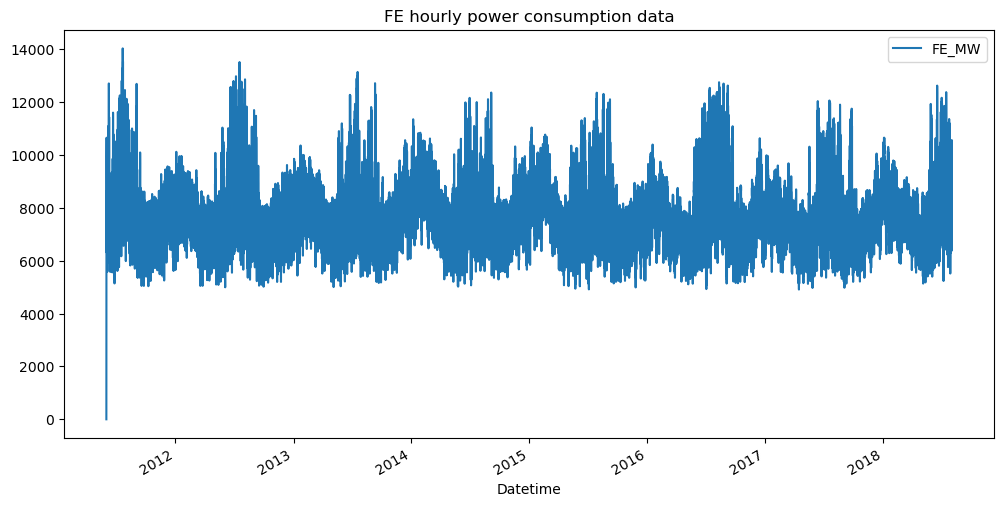

In [11]:
data.plot(figsize=(12,6))
plt.title('FE hourly power consumption data')

In [12]:
data.isna().sum()

FE_MW    0
dtype: int64

In [13]:
# aggregate the data from hours to day.

data = data.resample('D').mean()

Text(0.5, 1.0, 'FE hourly power consumption data')

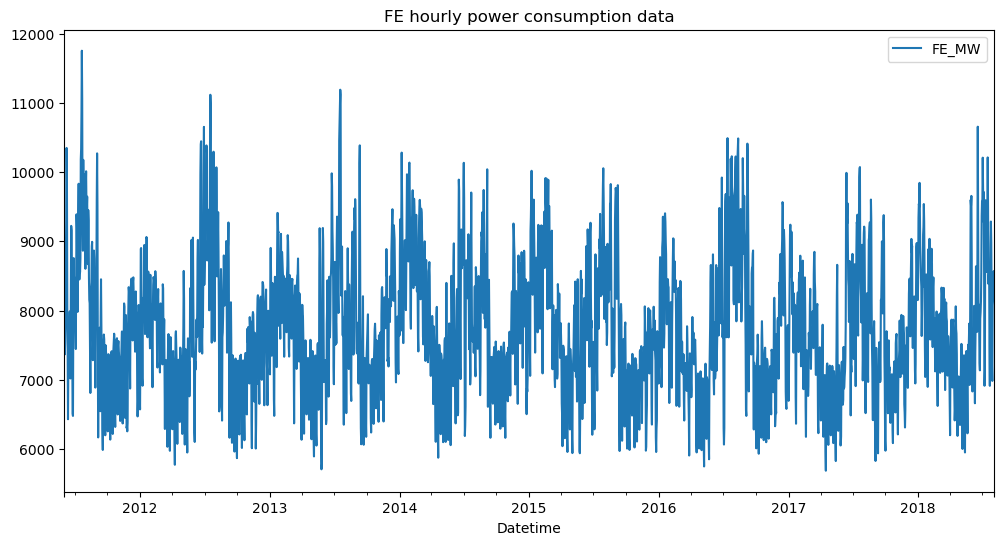

In [14]:
data.plot(figsize=(12,6))
plt.title('FE hourly power consumption data')

In [15]:
data.head()

,FE_MW
Datetime,
2011-06-01,9047.086957
2011-06-02,7742.416667
2011-06-03,7366.166667
2011-06-04,7529.125000
2011-06-05,7846.291667


In [16]:
data.shape

(2621, 1)

**Predicting the number of monthly riders with LSTM**

In [17]:
print(len(data))


2621


In [18]:

train = data.iloc[:2500]
test = data.iloc[2500:]

print(train.shape, test.shape)

(2500, 1) (121, 1)


In [19]:
scaler = MinMaxScaler(feature_range=(0,1))

In [20]:
scaler.fit(train)
scaled_train = scaler.transform(train)


In [21]:
scaled_test = scaler.transform(test)

In [22]:
scaled_train.shape

(2500, 1)

In [23]:
n_input = 24
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1, sampling_rate=1)

In [24]:
x, y = generator[1]
print(f'Given the Array: \n{x.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.33900505 0.27700072 0.30385553 0.35612318 0.51151852 0.59460981
 0.76855838 0.68535723 0.38989941 0.30272256 0.12256669 0.25988258
 0.26137261 0.28238404 0.33300374 0.37921516 0.30531122 0.21963127
 0.41380163 0.58294366 0.57219762 0.43839736 0.30525629 0.1357572 ]
Predict this y: 
 [[0.13049061]]


In [25]:
x.shape

(1, 24, 1)

In [26]:
y.shape

(1, 1)

# Build LSTM model

In [27]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [28]:
# check = ModelCheckpoint('model_lstm/', verbose=2, save_best_only=True)
model.compile(loss=MeanSquaredError(),
                   optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 24, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 24, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-traina

In [29]:
model.fit(generator,epochs=20)

Epoch 1/20
2476/2476 [==============================] - 135s 46ms/step - loss: 0.0249 - root_mean_squared_error: 0.1577
Epoch 2/20
2476/2476 [==============================] - 114s 46ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451
Epoch 3/20
2476/2476 [==============================] - 134s 54ms/step - loss: 0.0205 - root_mean_squared_error: 0.1433
Epoch 4/20
2476/2476 [==============================] - 136s 55ms/step - loss: 0.0202 - root_mean_squared_error: 0.1422
Epoch 5/20
2476/2476 [==============================] - 141s 57ms/step - loss: 0.0199 - root_mean_squared_error: 0.1411
Epoch 6/20
2476/2476 [==============================] - 137s 55ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385
Epoch 7/20
2476/2476 [==============================] - 139s 56ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387
Epoch 8/20
2476/2476 [==============================] - 142s 57ms/step - loss: 0.0187 - root_mean_squared_error: 0.1366
Epoch 9/20
2476/2476 [==================

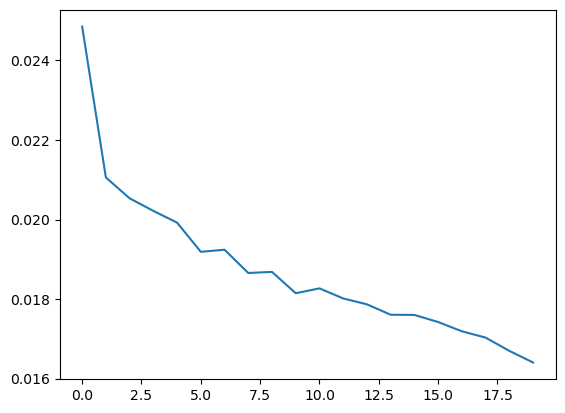

In [30]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [31]:
# Predict the last train batch


last_train_batch = scaled_train[-24:]

last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)

1/1 [==============================] - 4s 4s/step


array([[0.24572927]], dtype=float32)

In [32]:
scaled_test[0]

array([0.35968689])

In [33]:
test_predictions = []

# first_eval_batch = scaled_train[-n_input:]
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
#     break

1/1 [==============================] - 0s 37ms/step


In [34]:
test_predictions 

[array([0.24572927], dtype=float32),
 array([0.24117889], dtype=float32),
 array([0.23748049], dtype=float32),
 array([0.23542994], dtype=float32),
 array([0.2352739], dtype=float32),
 array([0.25866017], dtype=float32),
 array([0.2691936], dtype=float32),
 array([0.24435882], dtype=float32),
 array([0.23563859], dtype=float32),
 array([0.23150867], dtype=float32),
 array([0.22989535], dtype=float32),
 array([0.23005903], dtype=float32),
 array([0.24294129], dtype=float32),
 array([0.24186024], dtype=float32),
 array([0.22810957], dtype=float32),
 array([0.22610402], dtype=float32),
 array([0.22622642], dtype=float32),
 array([0.22339348], dtype=float32),
 array([0.23788828], dtype=float32),
 array([0.2578833], dtype=float32),
 array([0.2526107], dtype=float32),
 array([0.22797802], dtype=float32),
 array([0.22110453], dtype=float32),
 array([0.22041853], dtype=float32),
 array([0.22877607], dtype=float32),
 array([0.22931296], dtype=float32),
 array([0.22964048], dtype=float32),
 arra

In [35]:
true_pred = scaler.inverse_transform(test_predictions)

In [36]:
test['Predicted_energy_consumption'] = true_pred

C:\Users\Surface\AppData\Local\Temp\ipykernel_8404\1442577618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_energy_consumption'] = true_pred


In [37]:
test.head()

,FE_MW,Predicted_energy_consumption
Datetime,,
2018-04-05,7867.916667,7176.407579
2018-04-06,7635.333333,7148.795289
2018-04-07,7154.000000,7126.352974
2018-04-08,6887.500000,7113.909987
2018-04-09,7819.166667,7112.963087


<AxesSubplot:xlabel='Datetime'>

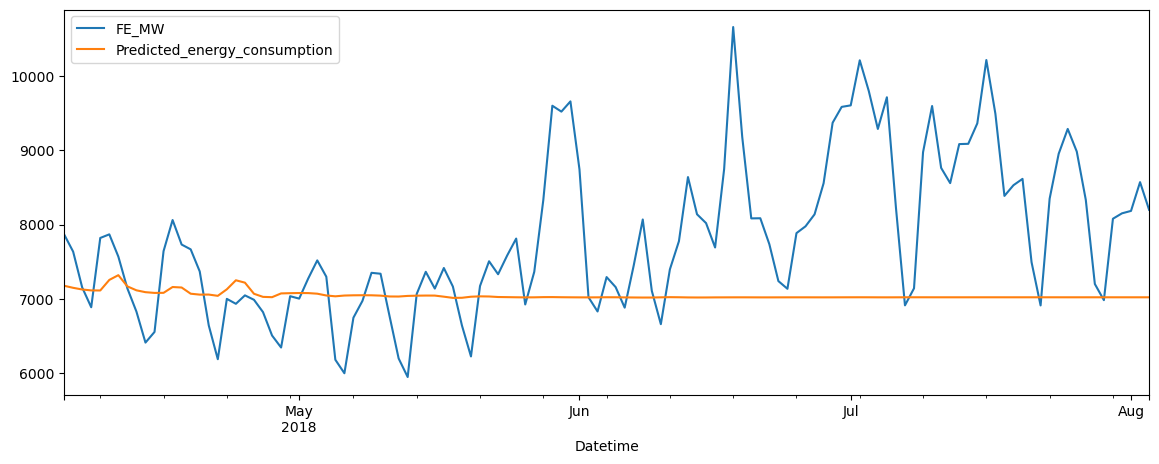

In [38]:
test.plot(figsize=(14,5))

In [39]:
rmse=sqrt(mean_squared_error(test['FE_MW'],test['Predicted_energy_consumption']))
print(rmse)

1289.6456924056295


In [40]:
model.save('hourly_energy.h5')

In [41]:
test['error'] = np.abs(test['FE_MW'] - test['Predicted_energy_consumption'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

C:\Users\Surface\AppData\Local\Temp\ipykernel_8404\4116629201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test['FE_MW'] - test['Predicted_energy_consumption'])
C:\Users\Surface\AppData\Local\Temp\ipykernel_8404\4116629201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index.date


date
2018-06-18    3634.955724
2018-07-16    3190.345447
2018-07-02    3186.648978
2018-07-03    2773.050453
2018-07-05    2690.722686
2018-05-31    2634.650441
2018-07-01    2580.657911
2018-05-29    2573.231163
2018-07-10    2571.981605
2018-06-30    2560.812062
Name: error, dtype: float64

#### The model was unable to learn the pattern correctly. It definitely requires more fine-tuning.